In [1]:
from astropy.table import Table, vstack, Column
from tqdm import tqdm
from astropy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.lines import Line2D
import warnings

In [14]:
decals_raw = Table.read('K_corrected_decals_data.csv', format='ascii')
decals = decals_raw[decals_raw['type'] != 'PSF']

control_sample = Table.read('K_corrected_control_sample.csv', format='ascii')

# Convertir la tabla de astropy a un DataFrame de pandas
df = decals.to_pandas()

# Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals = Table.from_pandas(df)

In [15]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')
    control_sample['n_' + filtro] = pd.to_numeric(control_sample['n_' + filtro], errors='coerce')
    control_sample['RE_' +filtro] = pd.to_numeric(control_sample['RE_' + filtro], errors = 'coerce')
    control_sample['e_n_' + filtro] = pd.to_numeric(control_sample['e_n_' + filtro], errors='coerce')
    control_sample['e_RE_' +filtro] = pd.to_numeric(control_sample['e_RE_' + filtro], errors = 'coerce')

/tmp/ipykernel_11152/3031267782.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=n_r, y=g_r_decals, cmap='Purples', shade=True, cbar=False)
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


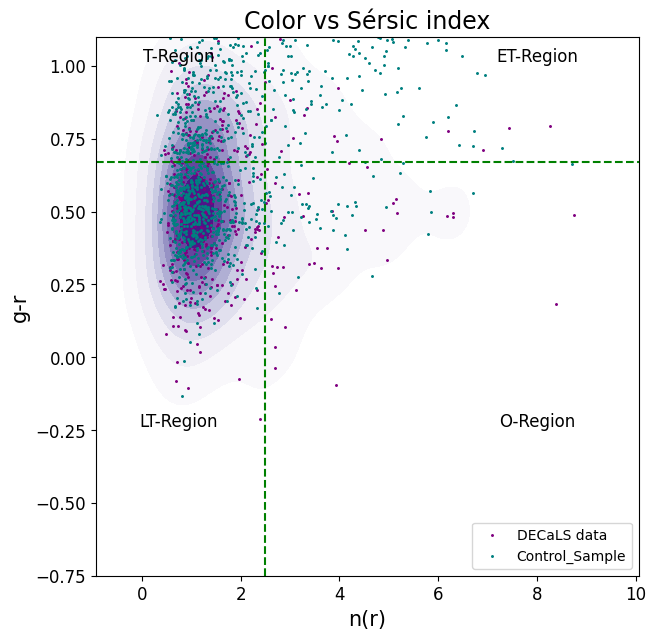

In [17]:
decals_no_zero = decals[decals['n_r']!=0.0]
g_r_decals = decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']
n_r = decals_no_zero['n_r']
cs_no_zero = control_sample[control_sample['n_r'] != 0.0]
g_r_cs = cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']
n_r_cs = cs_no_zero['n_r']
plt.figure(figsize=(7, 7))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Purples', shade=True, cbar=False)
#sns.kdeplot(x=n_r_cs, y=g_r_cs, cmap='Oranges', shade=True, cbar=False)

plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='DECaLS data', s=5, color='purple')
plt.scatter(cs_no_zero['n_r'], g_r_cs, marker='.', label='Control_Sample', s=5, color='teal')

plt.ylim(-0.75, 1.1)
#plt.xlim(0, )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('g-r', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right')
plt.axhline(y=0.67, color='green', linestyle='--')

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='green', linestyle='--')

# Agregar texto en coordenadas específicas
plt.text(0.75, 1, 'T-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=12, ha='center', va='bottom', color='black')

plt.show()


In [18]:
sfr_decals = Table.read('sfr_decals_k_corrected.csv', format='ascii')
sfr_decals.rename_column('logSFR_NUV', 'log_SFR')
#sfr_decals.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_decals.rename_column('stellar_mass', 'stellar_mass_phot')
sfr_decals.rename_column('zmemb', 'z')

H_0 = 67.4 #km/s/Mpc
c = 300000

sfr_decals['Distance (Mpc)'] = (sfr_decals['z']*c)/H_0
sfr_decals['M_i'] = sfr_decals['m_i_corrected'] - 5*np.log10(sfr_decals['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_decals['ebv']
sfr_decals['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_decals['m_g_corrected'] - sfr_decals['m_i_corrected']) - 0.4*sfr_decals['M_i'])


type_column = Column(['SFCG Galaxy'] * len(sfr_decals), name='Nature')
sfr_decals.add_column(type_column)
mask = ~np.isnan(sfr_decals['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_decals = sfr_decals[mask]
sfr_decals

<Table length=246>
Group  Gal     z     ...         M_i         stellar_mass_phot_i    Nature  
int64 int64 float64  ...       float64             float64          str11   
----- ----- -------- ... ------------------- ------------------- -----------
    3     1 0.041719 ...  -17.54311965493355   8.595671598293944 SFCG Galaxy
    3     4 0.041719 ... -21.823575286030067   10.51817879286663 SFCG Galaxy
   10     4 0.051799 ... -21.405866646406267  10.302368834120726 SFCG Galaxy
   10     1 0.051799 ... -19.130354824305346   9.388686986319183 SFCG Galaxy
   13     1 0.041095 ... -21.158819565812568  10.460089143057552 SFCG Galaxy
   13     3 0.041095 ... -17.186724742475022   8.631861990492261 SFCG Galaxy
   13     4 0.041095 ... -18.989514580986175   9.299263931170655 SFCG Galaxy
   14     2  0.07588 ... -20.919610586764065  10.360883998857778 SFCG Galaxy
   14     1 0.077266 ...  -21.31547922346903  10.398249617405515 SFCG Galaxy
  ...   ...      ... ...                 ...                 ...         ...
  266     6 0.031292 ... -17.283926332892833   8.541399353373375 SFCG Galaxy
  266     3 0.031292 ...  -18.34226247174002   8.844722998647633 SFCG Galaxy
  272     2 0.091141 ...  -20.75974237840081  10.121792842726169 SFCG Galaxy
  272     3 0.091141 ... -20.473268841068112   9.968515818310848 SFCG Galaxy
  272     6 0.091141 ... -20.450212997672086    9.80500632267722 SFCG Galaxy
  272     1 0.014046 ...  -18.86172537208269   9.205863095393733 SFCG Galaxy
  273     4   0.0691 ...  -20.72008994424506    9.92444427305801 SFCG Galaxy
  273     5 0.069293 ... -15.999878458858937   7.820349512621498 SFCG Galaxy
  279     6 0.099919 ... -22.098422077128333  11.011867117441103 SFCG Galaxy
  279     2 0.027162 ... -19.472985543116287    9.47930335860477 SFCG Galaxy

9.768608773092591 6.017861272398006 11.956775132098182


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


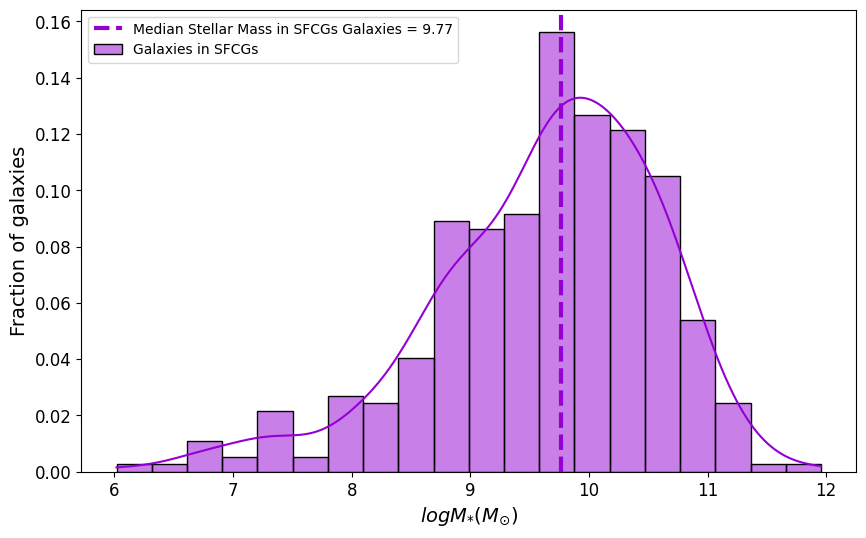

In [9]:
mass = sfr_decals['stellar_mass_phot_i']
# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass, kde=True, stat='probability', alpha=0.5, bins=20, color='darkviolet', label='Galaxies in SFCGs')

# Calcular medianas
median_x = np.median(mass)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median Stellar Mass in SFCGs Galaxies = 9.77')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('Stellar Mass of the SFCG Galaxies', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend()
print(median_x, min(mass), max(mass))
plt.show()

In [19]:
type_column_cs = Column(['Field Galaxy'] * len(control_sample), name='Nature')
control_sample.add_column(type_column_cs)
control_sample

<Table length=1200>
Group  Gal    ID  ...   m_r_corrected      m_z_corrected       Nature   
int64 int64 int64 ...      float64            float64          str12    
----- ----- ----- ... ------------------ ------------------ ------------
    2     2  4345 ... 17.184430474143486 16.892502838445232 Field Galaxy
    3     3   446 ...   17.6732332938549 17.385759569978944 Field Galaxy
    5     5  3209 ...  17.59582799515411  17.62790622994033 Field Galaxy
    7     7  6365 ...  17.35950036410777 17.110449088171034 Field Galaxy
    8     8  6935 ...  17.90961081844863 17.712160524337257 Field Galaxy
    9     9  8558 ... 17.849254875908567   17.8343329494378 Field Galaxy
   10    10  1131 ... 16.442617808015083   16.3253989201472 Field Galaxy
   11    11 14769 ...  17.56848502753937 17.416541610367872 Field Galaxy
   13    13  1363 ...  17.28113447152044 16.967256839240754 Field Galaxy
  ...   ...   ... ...                ...                ...          ...
 1273  1273  3036 ...  21.95359963929314  22.27833904043956 Field Galaxy
 1274  1274  4933 ...  14.65767049201838 14.174819981829197 Field Galaxy
 1275  1275  4811 ...  17.46054013118718  17.26319235606048 Field Galaxy
 1276  1276  3743 ... 17.072004213758785 16.950888328473944 Field Galaxy
 1277  1277   689 ... 17.105713441178473 16.482630167090996 Field Galaxy
 1278  1278  4935 ... 17.527880417890646 17.060101942900573 Field Galaxy
 1280  1280  4972 ... 15.973246731335522 15.484296600347857 Field Galaxy
 1282  1282  1928 ...  17.63179139676918 17.322771135050832 Field Galaxy
 1283  1283  1812 ... 15.390039329264313 14.671080963730613 Field Galaxy
 1284  1284 10549 ... 17.047318162474916  16.53485229932842 Field Galaxy

In [11]:
sfr_decals_plots = sfr_decals['Group', 'Gal', 'z', 'ra', 'dec', 'log_SFR', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'e_n_r', 'e_RE_r']
control_sample_plots = control_sample['Group', 'Gal', 'z', 'ra', 'dec', 'log_SFR', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'e_n_r', 'e_RE_r']

cg_cs = vstack([sfr_decals_plots, control_sample_plots])

KeyError: 'mag_g'

In [25]:
cg_cs = cg_cs[cg_cs['log_SFR'] > -10]
cg_cs['log_sSFR'] = cg_cs['log_SFR'] - cg_cs['stellar_mass_phot_i']
cg_cs['RE_g'] = cg_cs['RE_g']*0.262
cg_cs['RE_r'] = cg_cs['RE_r']*0.262
cg_cs['e_RE_r'] = cg_cs['e_RE_r']*0.262
cg_cs['RE_i'] = cg_cs['RE_i']*0.262
cg_cs['RE_z'] = cg_cs['RE_z']*0.262

cg_cs['Distance (Mpc)'] = 300000*cg_cs['z']/67.4
cg_cs['RE_g(kpc)'] = (cg_cs['RE_g']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_r(kpc)'] = (cg_cs['RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['e_RE_r(kpc)'] = (cg_cs['e_RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_i(kpc)'] = (cg_cs['RE_i']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_z(kpc)'] = (cg_cs['RE_z']*cg_cs['Distance (Mpc)'])/206.265

In [26]:
cg_cs = cg_cs[cg_cs['RE_g(kpc)'] < 30]
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'SFCG Galaxy']))
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'Field Galaxy']))

4.620169540688382
4.370438890767481


In [28]:
print(len(cg_cs))
cg_cs = cg_cs[(~np.isinf(cg_cs['stellar_mass_phot_i'])) & (~np.isnan(cg_cs['stellar_mass_phot_i'])) & (cg_cs['n_g'] != 0.0)]
print(len(cg_cs))

1543
1496


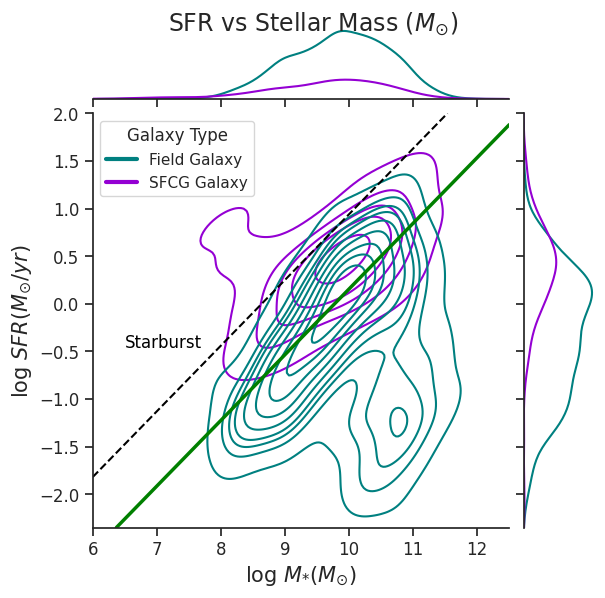

In [29]:
# Ignorar los warnings
warnings.filterwarnings("ignore")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=cg_cs['log_SFR']
x=cg_cs['stellar_mass_phot_i']
sur=cg_cs['Nature']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=cg_cs,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)
# Añadir un título al gráfico
g.fig.suptitle("SFR vs Stellar Mass $(M_{\odot})$", fontsize=17)
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga con el gráfico

# Añadir una recta que pase por el punto (x, y) = (0.25, 0.25)
g.ax_joint.axline((9, 0.25), slope=0.69, color='black', linestyle='--')
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.5)
g.ax_joint.set_ylim(-2.35, 2)
g.ax_joint.text(6.5, -0.5, 'Starburst', color='black', fontsize=12, verticalalignment='bottom')
# Añadir una segunda recta continua con un label
g.ax_joint.axline((10.5, 0.5), slope=0.69, color='green', linestyle='-', label='Main sequence, Sargent+14', linewidth=2.5)
g.set_axis_labels("log $M_{*} (M_{\odot})$", "log $SFR (M_{\odot}/yr)$", fontsize=15)
g.ax_joint.tick_params(axis='both', labelsize=12)  # Cambia 12 por el tamaño de fuente deseado
# Mostrar la leyenda con el label de la recta continua
g.ax_joint.legend()

# Definir los handles y labels
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda al gráfico
g.ax_joint.legend(handles=handles, labels=labels, title="Galaxy Type", loc="upper left")

plt.show()

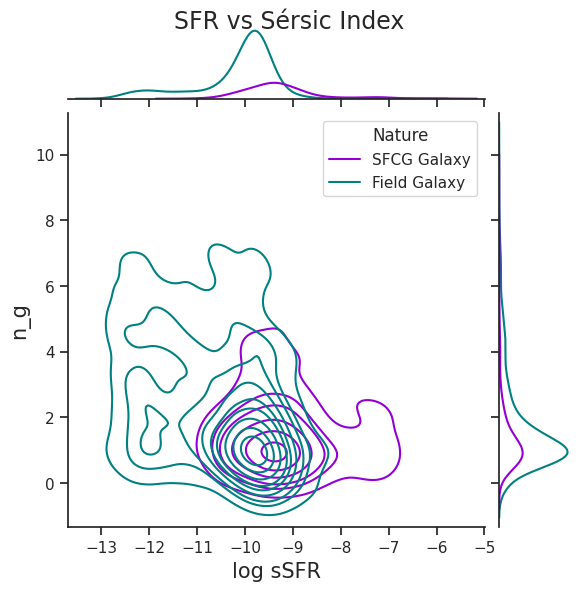

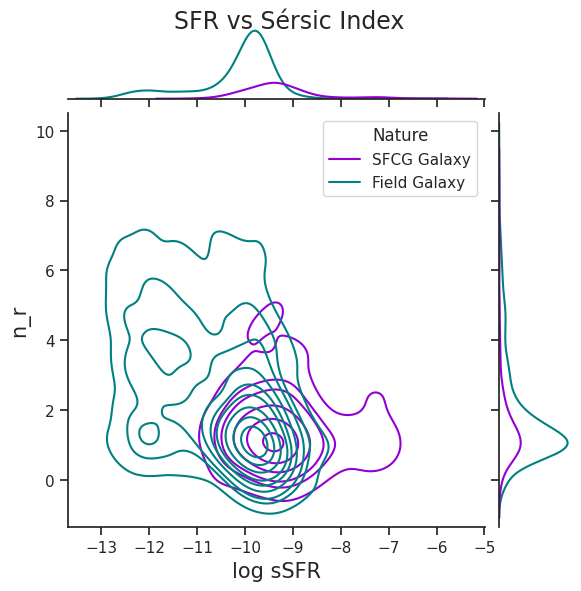

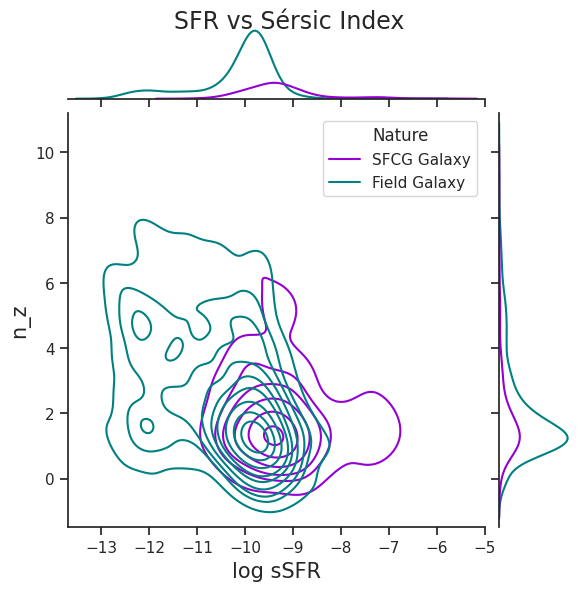

In [12]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    
    # Añadir títulos
    g.set_axis_labels("log sSFR", f"{col}", fontsize=15)
    g.fig.suptitle(f"SFR vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()


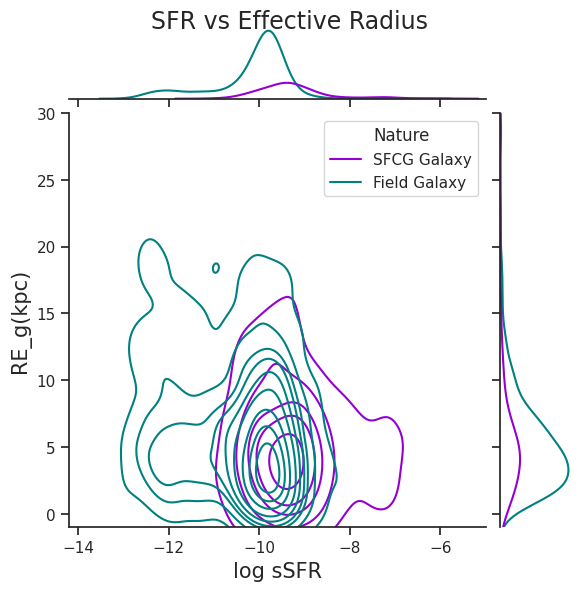

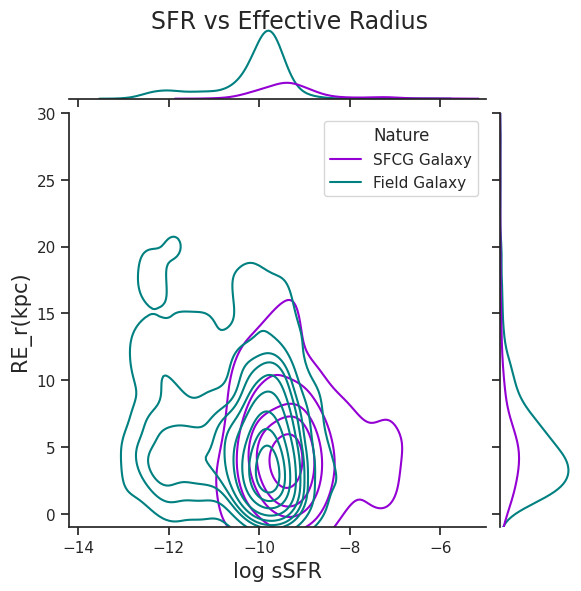

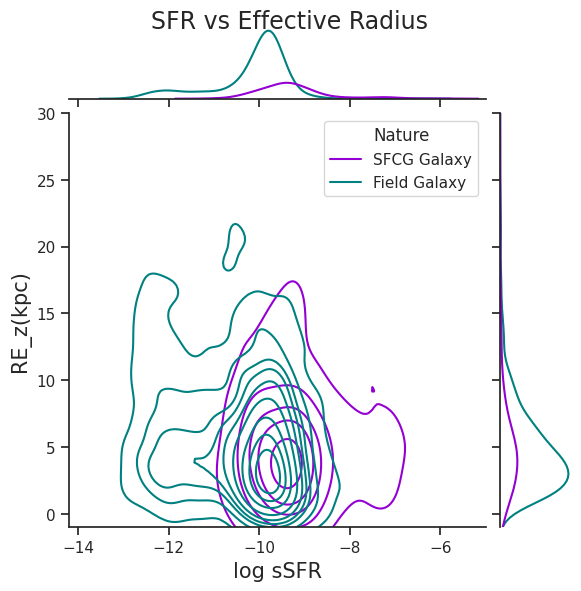

In [13]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-14.2, -5)
    g.ax_joint.set_ylim(-1, 30)
    # Añadir títulos
    g.set_axis_labels("log sSFR", f"{col}", fontsize=15)
    g.fig.suptitle(f"SFR vs Effective Radius", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

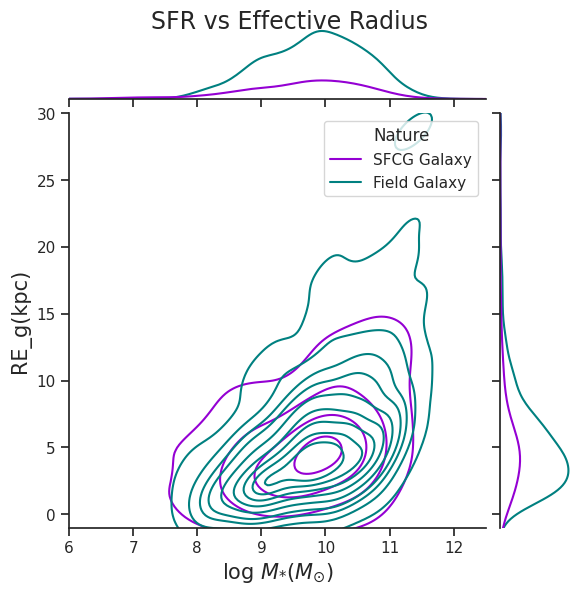

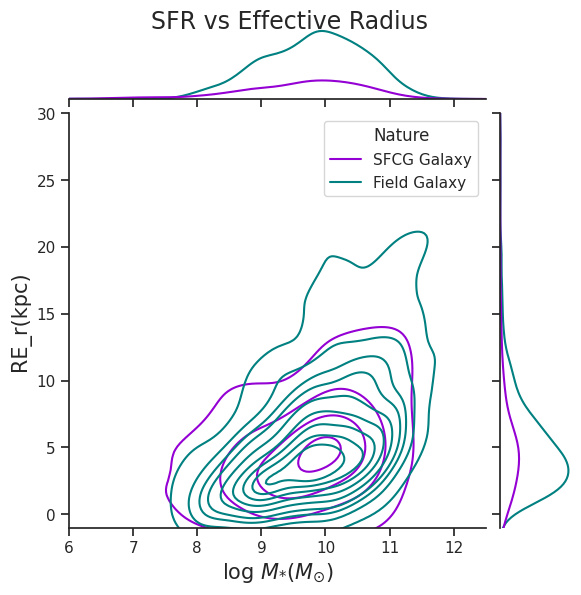

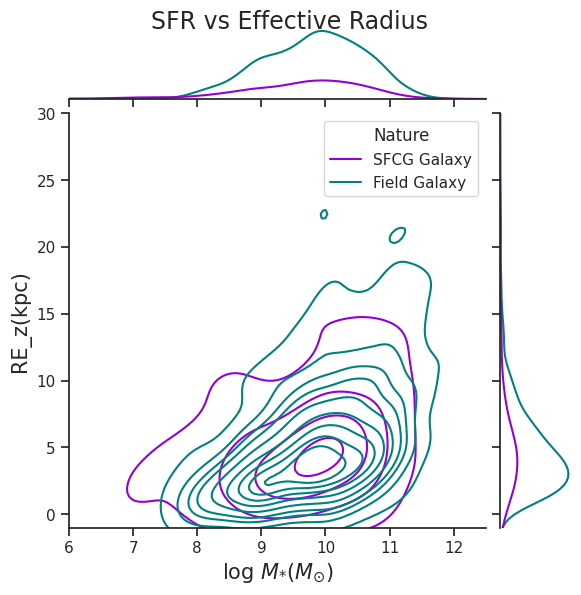

In [14]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['stellar_mass_phot_i']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(6, 12.5)
    g.ax_joint.set_ylim(-1, 30)
    # Añadir títulos
    g.set_axis_labels("log $M_{*} (M_{\odot})$", f"{col}", fontsize=15)
    g.fig.suptitle(f"SFR vs Effective Radius", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

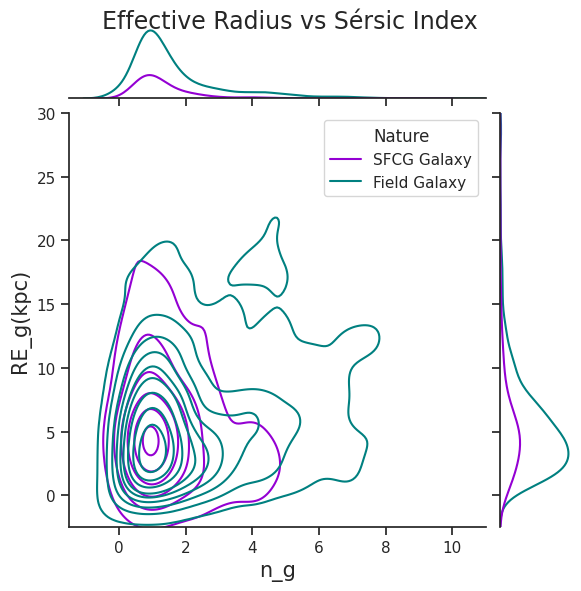

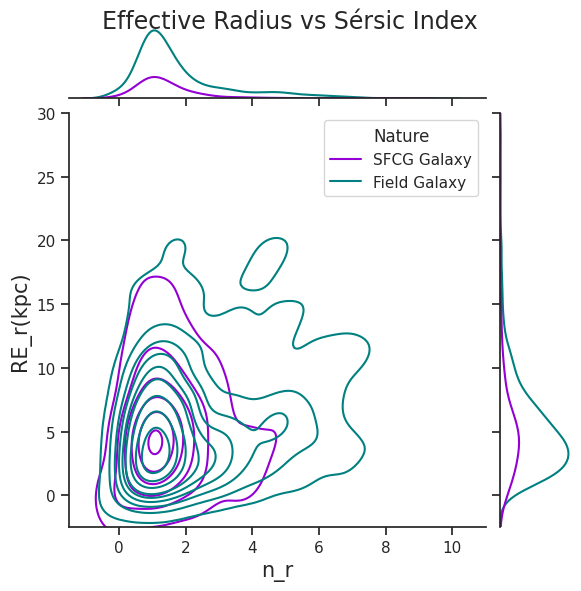

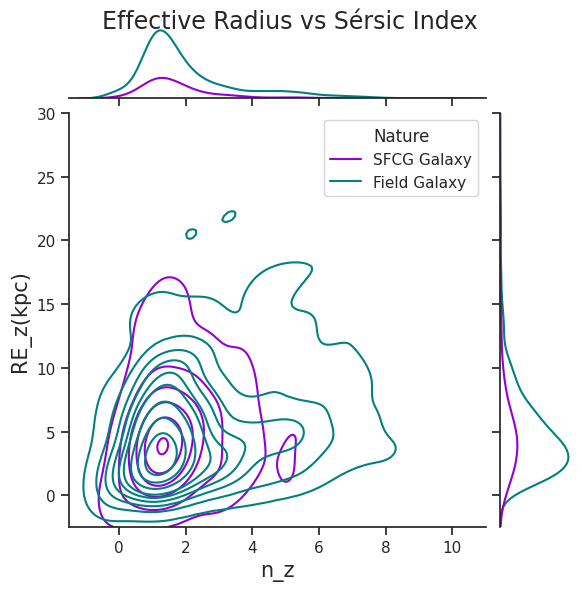

In [15]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col_x, col_y in zip(x_columns, y_columns):
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=cg_cs[col_x], y=cg_cs[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-1.5, 11)
    g.ax_joint.set_ylim(-2.5, 30)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Effective Radius vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

## Separar las galaxias por región en el plot de g-r vs n

In [30]:
late_type = cg_cs[((cg_cs['mag_g'] - cg_cs['mag_r']) < 0.67) & (cg_cs['n_r'] <= 2.5)]
transition = cg_cs[((cg_cs['mag_g'] - cg_cs['mag_r']) > 0.67) & (cg_cs['n_r'] <= 2.5)]
early_type = cg_cs[((cg_cs['mag_g'] - cg_cs['mag_r']) > 0.67) & (cg_cs['n_r'] > 2.5)]
other = cg_cs[((cg_cs['mag_g'] - cg_cs['mag_r']) < 0.67) & (cg_cs['n_r'] > 2.5)]
print(len(late_type), len(transition), len(early_type), len(other))
transition = transition[(transition['n_r'] != 0.0) & (transition['RE_r(kpc)'] != 0.0)]

854 346 198 90


[[ 3.28358209 16.38913234]
 [70.44776119 54.1630149 ]
 [17.91044776 24.01402279]
 [ 8.35820896  5.43382997]]


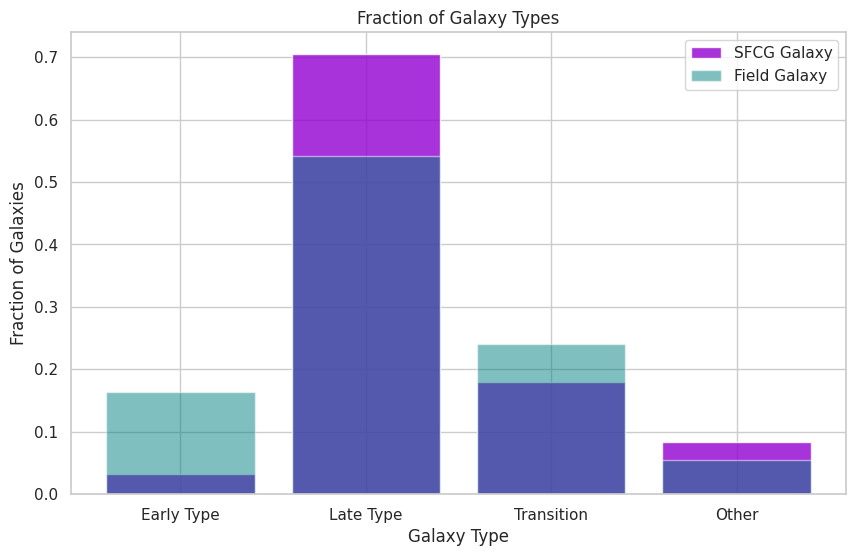

In [31]:
sns.set_theme(style='whitegrid')

tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other']

tablas = [early_type, late_type, transition, other]

# Contar el total de galaxias por 'Nature' en todas las tablas
total_sfcg = 0
total_field = 0
for tabla in tablas:
    total_sfcg += np.sum(tabla['Nature'] == 'SFCG Galaxy')
    total_field += np.sum(tabla['Nature'] == 'Field Galaxy')

# Crear una lista para almacenar las fracciones para cada tabla
fractions = []
for tabla in tablas:
    sf_galaxies = np.sum(tabla['Nature'] == 'SFCG Galaxy')
    field_galaxies = np.sum(tabla['Nature'] == 'Field Galaxy')
    
    # Calcular la fracción respecto al total
    sf_fraction = sf_galaxies / total_sfcg
    field_fraction = field_galaxies / total_field
    
    # Añadir las fracciones a la lista
    fractions.append([sf_fraction, field_fraction])

# Convertir los resultados en un array de numpy
fractions = np.array(fractions)
print(fractions*100)
# Crear el histograma apilado
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las posiciones de los bins (uno para cada tabla)
bins = np.arange(len(tabla_names))

bar1 = ax.bar(bins, fractions[:, 0], alpha = 0.8, label='SFCG Galaxy', color='darkviolet')
bar2 = ax.bar(bins, fractions[:, 1], alpha = 0.5, label='Field Galaxy', color='teal')

ax.set_xticks(bins)
ax.set_xticklabels(tabla_names)
ax.set_xlabel('Galaxy Type')
ax.set_ylabel('Fraction of Galaxies')
ax.set_title('Fraction of Galaxy Types')
ax.legend()

plt.show()

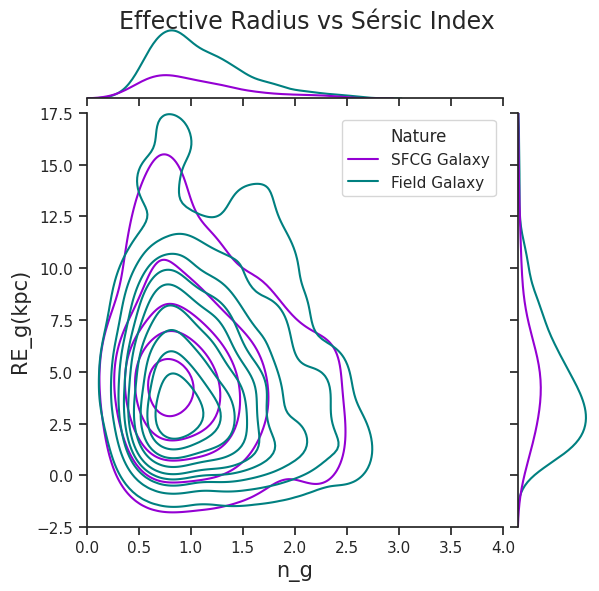

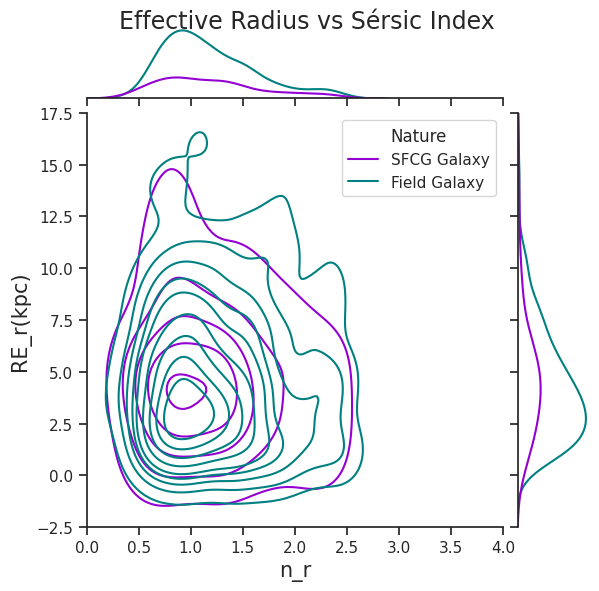

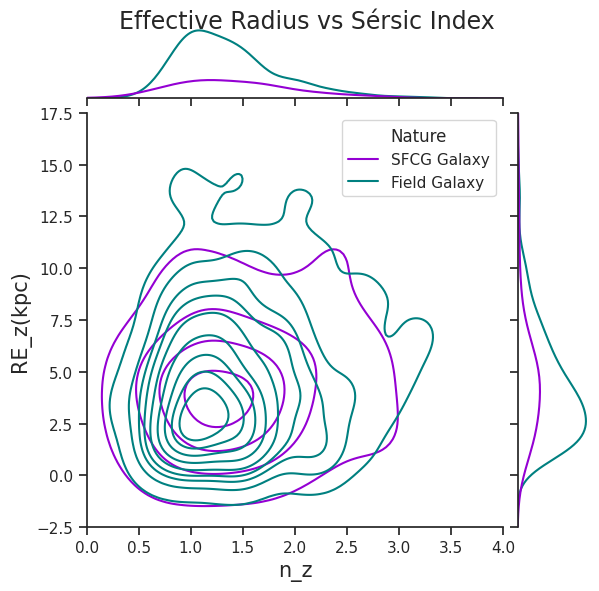

In [34]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=late_type,
        x=late_type[col_x], y=late_type[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 4)
    g.ax_joint.set_ylim(-2.5, 17.5)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Effective Radius vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

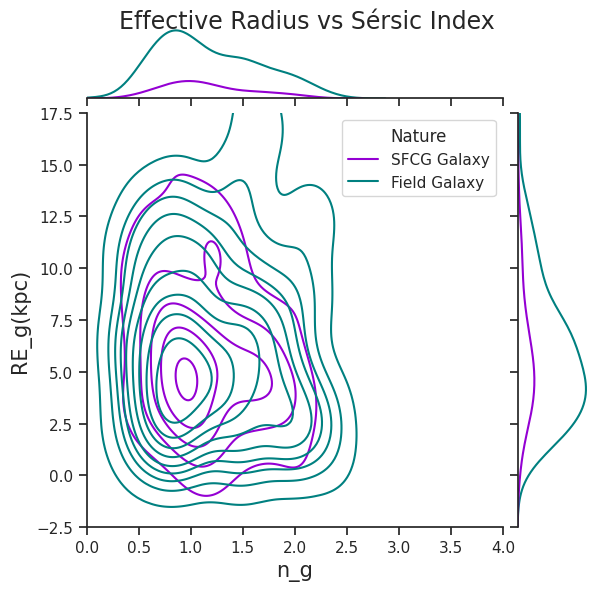

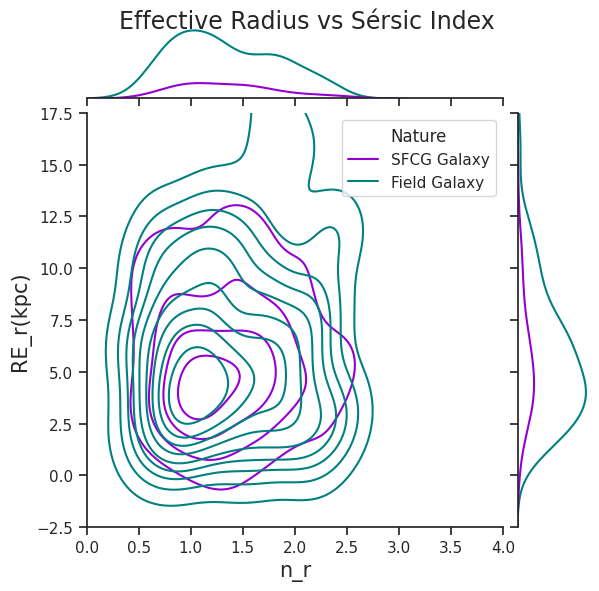

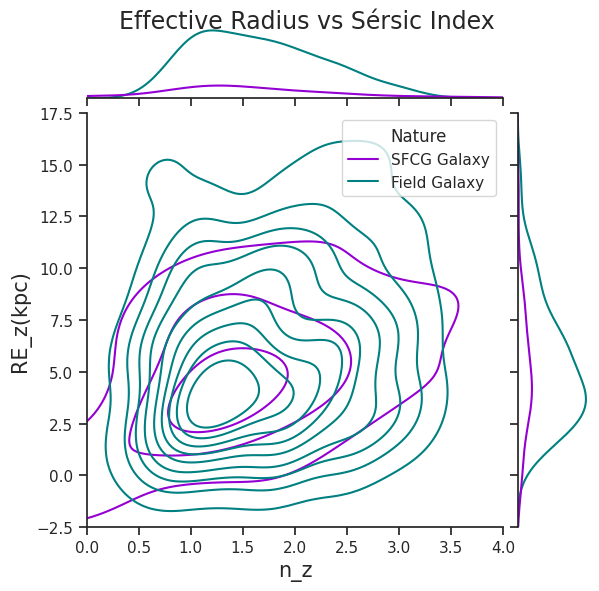

In [35]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=transition,
        x=transition[col_x], y=transition[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 4)
    g.ax_joint.set_ylim(-2.5, 17.5)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Effective Radius vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

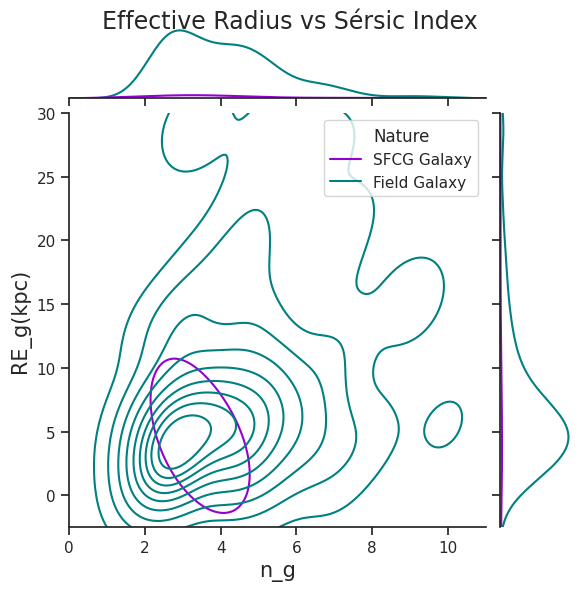

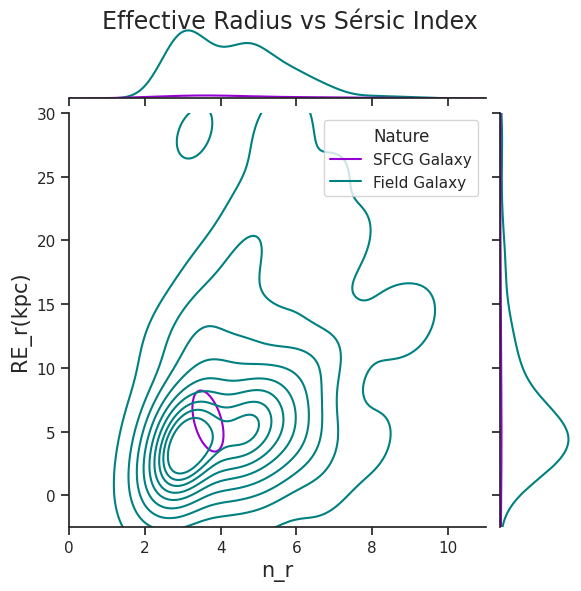

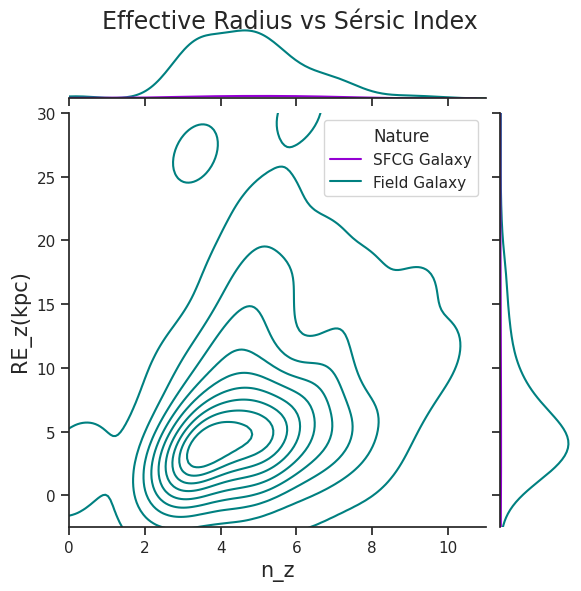

In [36]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = early_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Crear el gráfico
for col_x, col_y in zip(x_columns, y_columns):    
    g = sns.jointplot(
        data=early_type,
        x=early_type[col_x], y=early_type[col_y], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
        )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 11)
    g.ax_joint.set_ylim(-2.5, 30)
    # Añadir títulos
    g.set_axis_labels(f"{col_x}", f"{col_y}", fontsize=15)
    g.fig.suptitle(f"Effective Radius vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()

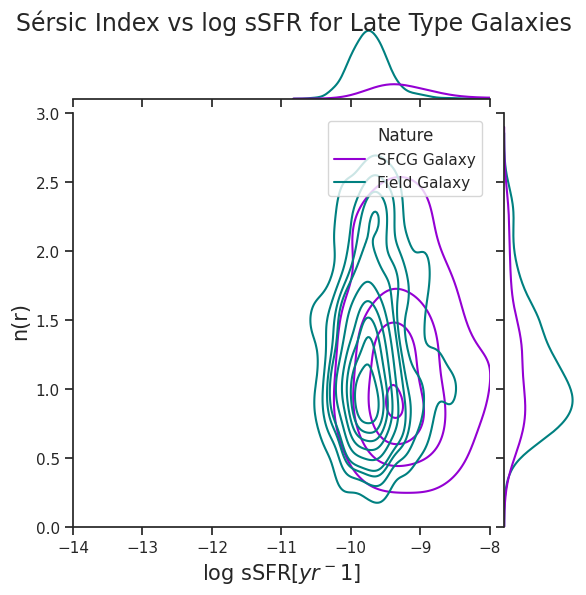

In [44]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x = late_type['log_sSFR']
y = late_type['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=late_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(0, 3)
# Añadir títulos
g.set_axis_labels(f"log sSFR[$yr^{-1}$]", f"n(r)", fontsize=15)
g.fig.suptitle(f"Sérsic Index vs log sSFR for Late Type Galaxies", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

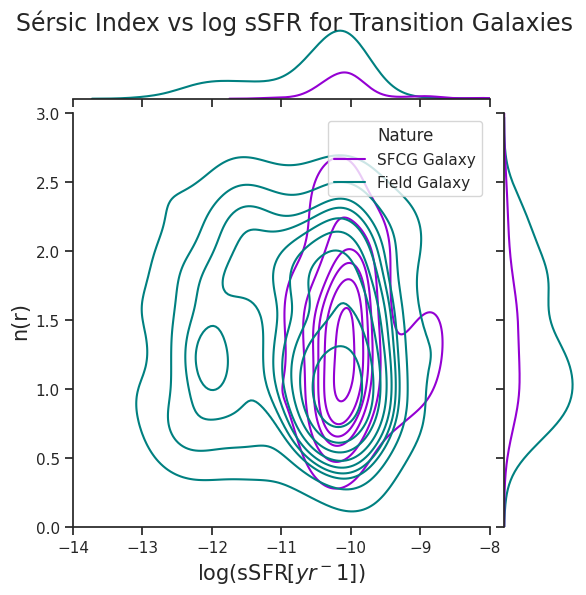

In [45]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x = transition['log_sSFR']
y = transition['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=late_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(0, 3)
# Añadir títulos
g.set_axis_labels(f"log(sSFR[$yr^{-1}$])", f"n(r)", fontsize=15)
g.fig.suptitle(f"Sérsic Index vs log sSFR for Transition Galaxies", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

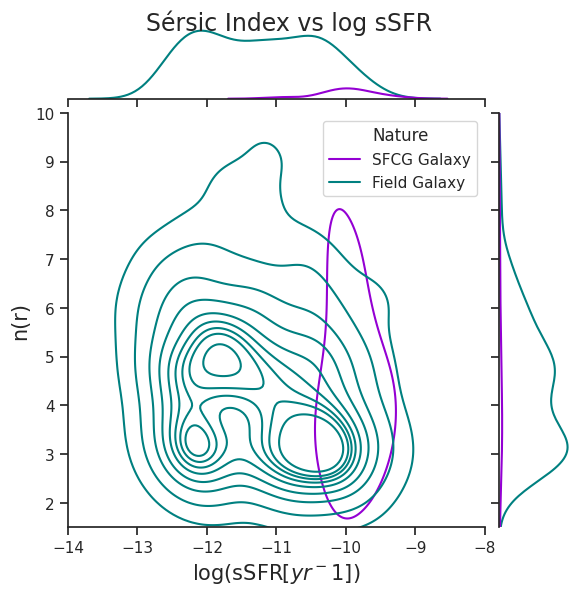

In [39]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = early_type['Nature']

# Lista de columnas que quieres graficar
x = early_type['log_sSFR']
y = early_type['n_r']
# Crear el gráfico
g = sns.jointplot(
    data=early_type,
    x=x, y=y, hue=sur,
    kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
    fill=False,  # No llenar las curvas
    palette=custom_palette
    )
# Limitar los ejes
g.ax_joint.set_xlim(-14, -8)
g.ax_joint.set_ylim(1.5, 10)
# Añadir títulos
g.set_axis_labels(f"log(sSFR[$yr^{-1}$])", f"n(r)", fontsize=15)
g.fig.suptitle(f"Sérsic Index vs log sSFR", fontsize=17)  # Título principal
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

# Mostrar el gráfico
plt.show()

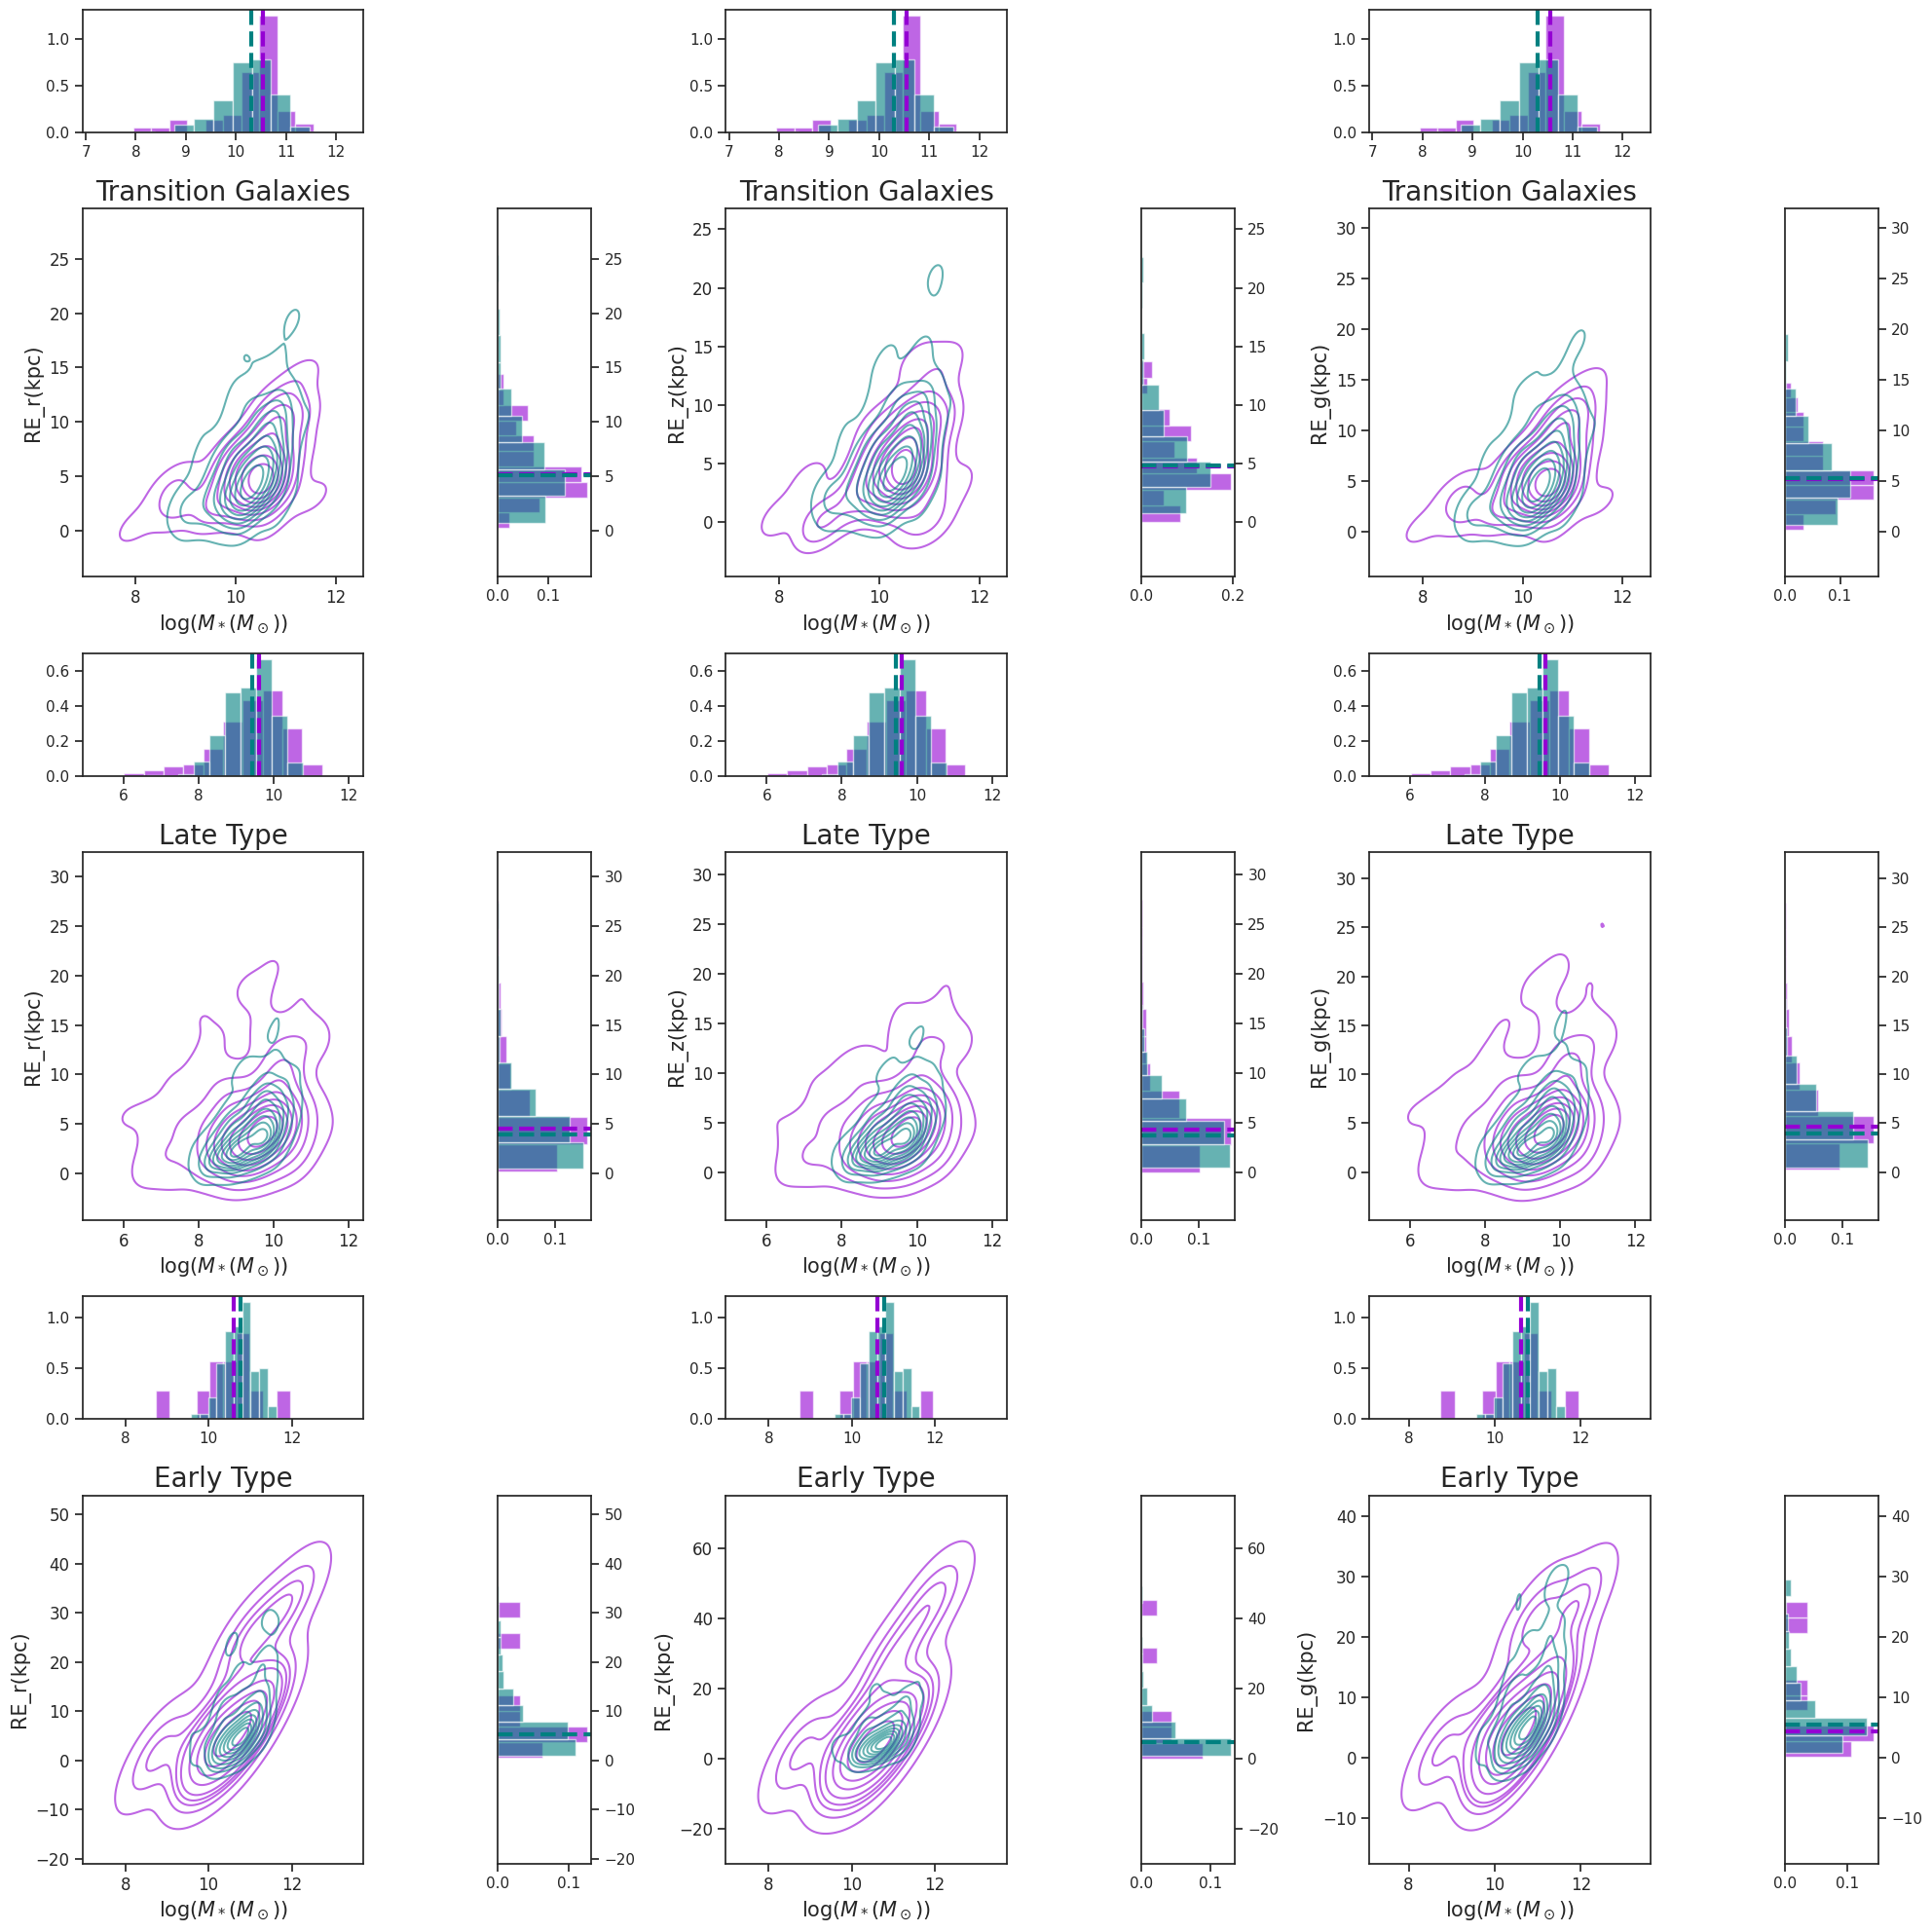

In [40]:
# Diccionario con los tipos de galaxias
galaxy_types = {'Early Type': early_type, 'Transition Galaxies': transition, 'Late Type': late_type}

# Colores para los dos tipos de galaxias
color_map = {'SFCG Galaxy': 'darkviolet', 'Field Galaxy': 'teal'}

# Figuras y ejes
fig, axs = plt.subplots(6, 6, figsize=(20, 20), gridspec_kw={'width_ratios': [6, 2, 6, 2, 6, 2], 'height_ratios': [2, 6, 2, 6, 2, 6]})

# Iterar sobre cada tipo de galaxia y cada columna de Re (g, r, z)
for i, (name, data) in enumerate(galaxy_types.items()):
    for j, re_col in enumerate(['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']):
        ax = axs[2*i-1, 2*j-2]
        ax_histx = axs[2*i-2, 2*j-2] #Panel del histograma en x
        ax_histy = axs[2*i-1, 2*j-1] #Panel del histograma en y
        

        ax.set_title(f'{name}', size=20)
        # Dividir los datos por Nature
        for nature_type, color in color_map.items():
            subset = data[data['Nature'] == nature_type]
            
            #Graficando KDE
            kde_plot = sns.kdeplot(x=subset['stellar_mass_phot_i'], y=subset[re_col], ax=ax, fill=False, color=color, alpha = 0.6, label=nature_type)
            
            # Calcular medianas
            median_x = np.median(subset['stellar_mass_phot_i'])
            median_y = np.median(subset[re_col])
            
            #Histogramas
            ax_histx.hist(subset['stellar_mass_phot_i'], bins=10, color=color, alpha=0.6, density=True)
            ax_histy.hist(subset[re_col], bins=10, color=color, alpha=0.6, orientation='horizontal', density=True)
        
            # Añadir líneas de la mediana
            ax_histx.axvline(median_x, color=color, linestyle='--', linewidth=3)
            ax_histy.axhline(median_y, color=color, linestyle='--', linewidth=3)
        
        # Personalización de ejes
        ax_histx.set_xlim(ax.get_xlim())
        ax_histy.set_ylim(ax.get_ylim())
        ax_histy.yaxis.set_label_position("left")
        ax_histy.yaxis.tick_right()
        # Etiquetas personalizadas de los ejes
        ax.set_xlabel(f'log($M_*(M_\odot)$)', size=15)
        ax.set_ylabel(f'{re_col}', size=15)
        # Cambiar el tamaño de las etiquetas de los ticks
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels, title='Galaxy Type', loc='upper left')
# Eliminar los ejes innecesarios (las filas 1, 3 y 5, columnas 2, 4 y 6)
for i in [0, 2, 4]:
    for j in [1, 3, 5]:
        axs[i, j].set_visible(False)
# Configuración global
plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)  # Reducir espacios entre subplots

plt.show()

In [41]:
median_re_late_sfcg = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_re_late_sfcg = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_re_transition_sfcg = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_error_re_transition_sfcg = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_re_early_sfcg = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_re_early_sfcg = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])

median_re_late_cs = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_error_re_late_cs = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_re_transition_cs = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_error_re_transition_cs = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_re_early_cs = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])
median_error_re_early_cs = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])

median_n_late_sfcg = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_n_late_sfcg = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_n_transition_sfcg = np.nanmedian(transition['n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_error_n_transition_sfcg = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_n_early_sfcg = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_n_early_sfcg = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'SFCG Galaxy'])

median_n_late_cs = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'Field Galaxy'])
median_error_n_late_cs = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'Field Galaxy'])
median_n_transition_cs = np.nanmedian(transition['n_r'][transition['Nature'] == 'Field Galaxy'])
median_error_n_transition_cs = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'Field Galaxy'])
median_n_early_cs = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'Field Galaxy'])
median_error_n_early_cs = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'Field Galaxy'])

print(f'Median effective radius for late type SFCG galaxies: {median_re_late_sfcg} \u00B1 {median_error_re_late_sfcg}')
print(f'Median effective radius for late type Field galaxies: {median_re_late_cs} \u00B1 {median_error_re_late_cs}')

print(f'Median effective radius for transition SFCG galaxies: {median_re_transition_sfcg} \u00B1 {median_error_re_transition_sfcg}')
print(f'Median effective radius for transition Field galaxies: {median_re_transition_cs} \u00B1 {median_error_re_transition_cs}')

print(f'Median effective radius for early type SFCG galaxies: {median_re_early_sfcg} \u00B1 {median_error_re_early_sfcg}')
print(f'Median effective radius for early type Field galaxies: {median_re_early_cs} \u00B1 {median_error_re_early_cs}')

print(f'Median Sérsic Index for late type SFCG galaxies: {median_n_late_sfcg} \u00B1 {median_error_n_late_sfcg}')
print(f'Median Sérsic Index for late type Field galaxies: {median_n_late_cs} \u00B1 {median_error_n_late_cs}')

print(f'Median Sérsic Index for transition SFCG galaxies: {median_n_transition_sfcg} \u00B1 {median_error_n_transition_sfcg}')
print(f'Median Sérsic Index for transition Field galaxies: {median_n_transition_cs} \u00B1 {median_error_n_transition_cs}')

print(f'Median Sérsic Index for early type SFCG galaxies: {median_n_early_sfcg} \u00B1 {median_error_n_early_sfcg}')
print(f'Median Sérsic Index for early type Field galaxies: {median_n_early_cs} \u00B1 {median_error_n_early_cs}')


Median effective radius for late type SFCG galaxies: 4.557406079311847 ± 0.0039763605215007835
Median effective radius for late type Field galaxies: 3.9411074550391483 ± 0.003836610965655155
Median effective radius for transition SFCG galaxies: 5.204172891234023 ± 0.004414883693379085
Median effective radius for transition Field galaxies: 5.0976492355452105 ± 0.005365301946208606
Median effective radius for early type SFCG galaxies: nan ± nan
Median effective radius for early type Field galaxies: 5.342681266018527 ± 0.015644057610485082
Median Sérsic Index for late type SFCG galaxies: 1.1250499999999999 ± 0.002
Median Sérsic Index for late type Field galaxies: 1.0913 ± 0.0019
Median Sérsic Index for transition SFCG galaxies: 1.3219500000000002 ± 0.0017499999999999998
Median Sérsic Index for transition Field galaxies: 1.2659500000000001 ± 0.002
Median Sérsic Index for early type SFCG galaxies: 3.9744 ± 0.0051
Median Sérsic Index for early type Field galaxies: 4.2341 ± 0.0121


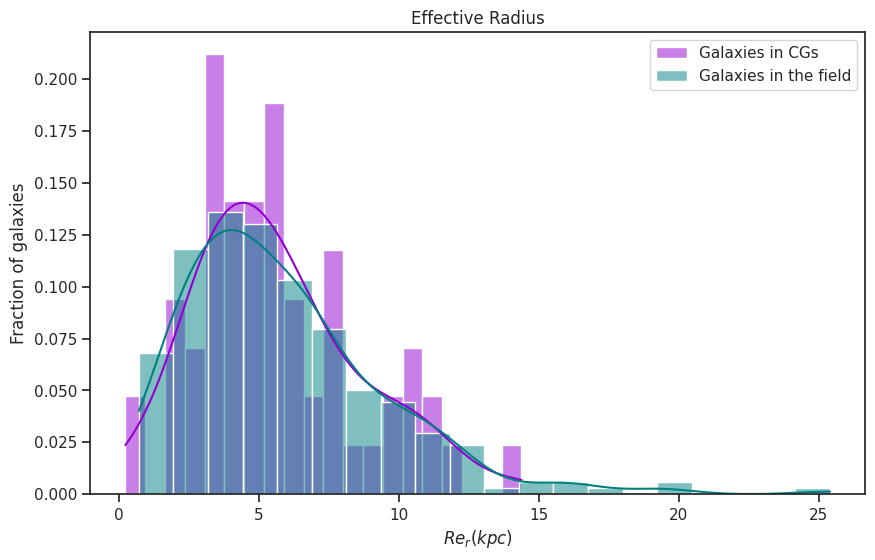

0.0840632603406326 0.8440973113291447


In [42]:
re_late_sfcg = transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy']
re_late_cs = transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(re_late_sfcg.min(), re_late_cs.min()), 
                        max(re_late_sfcg.max(), re_late_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(re_late_sfcg, kde=True, stat='density', alpha=0.5, bins=20, color='darkviolet', label='Galaxies in CGs')
sns.histplot(re_late_cs, kde=True, stat='density', alpha=0.5, bins=20, color='teal', label='Galaxies in the field')

# Etiquetas y título
plt.xlabel('$Re_{r} (kpc)$')
plt.ylabel('Fraction of galaxies')
plt.title('Effective Radius')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(re_late_sfcg, re_late_cs)
print(ks_stat, p_value)

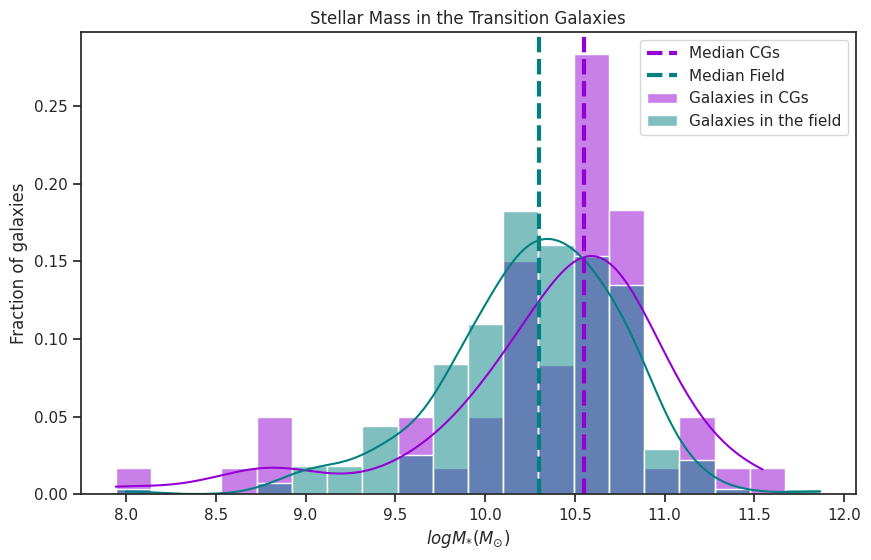

0.2351581508515815 0.0069713295048170944


In [43]:
mass_transition_sfcg = transition['stellar_mass_phot_i'][transition['Nature'] == 'SFCG Galaxy']
mass_transition_cs = transition['stellar_mass_phot_i'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(mass_transition_sfcg.min(), mass_transition_cs.min()), 
                        max(mass_transition_sfcg.max(), mass_transition_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass_transition_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='Galaxies in CGs')
sns.histplot(mass_transition_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Galaxies in the field')

# Calcular medianas
median_x = np.median(mass_transition_sfcg)
median_x_2 = np.median(mass_transition_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median CGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$')
plt.ylabel('Fraction of galaxies')
plt.title('Stellar Mass in the Transition Galaxies')
plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_transition_sfcg, mass_transition_cs)
print(ks_stat, p_value)